In [1]:
import os
from tifffile import tifffile
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mp
import pandas as pd
import trackpy as tp
from skimage import morphology, filters, measure, segmentation
from scipy import stats
from scipy.ndimage import center_of_mass

def normalize_image(input_im):
    '''
    normalize images to be between 0 and 1 while clipping extrema on either side
    '''
    new_ones = np.percentile(input_im, 99.9)
    new_zeros = np.percentile(input_im, 0.01)
    output_im = (input_im - new_zeros)/(new_ones - new_zeros)
    output_im[output_im < 0] = 0
    output_im[output_im > 1] = 1
    return(output_im)

In [2]:
# traverse directory, collect paths to tif files
parent_1 = '/home/jason/Downloads/ModelDataset_20210812/60X/'
parent_2 = '/home/jason/Downloads/ModelDataset_20210812/60X/60X_NEW/'
parent_3 = '/home/jason/Downloads/ModelDataset_20210812/100X/'

file_names = []
path_names = []

for parent in [parent_1, parent_2, parent_3]:
    file_list = os.listdir(parent)
    for f in file_list:
        if '.tif' in f:
            file_names.append(f)
            path_names.append(parent + f)
    
file_names = np.sort(file_names)
path_names = np.array(path_names)[np.argsort(file_names)]

In [3]:
PBD_Stack = []
RBD_Stack = []
BIN_Stack = []

unique_prefixes = np.sort(np.unique([i[:-7] for i in file_names]))

rictorko_filter_out = ['60X_Cell1_', '60X_Cell16_', '60X_Cell18', 'KO_Cell4']

ko_keep = []
for i in unique_prefixes:
    fout = np.any([j in i for j in rictorko_filter_out])
    if ('RictorKO' in i) & (not fout):
        ko_keep.append(True)
    else:
        ko_keep.append(False)
ko_keep = np.array(ko_keep)
                
wt_num_filter_out = [5, 6, 14]
wt_keep = [('WT' in i) and (int(i.split('_')[-2].strip('Cell')) not in wt_num_filter_out) for i in unique_prefixes]  
    
kept_prefixes = []

count = 0

for up in unique_prefixes:
    
    if ko_keep[count] | wt_keep[count]:

        isolated_tifs = path_names[np.where([up in i for i in path_names])]

        pbd_tif_path = isolated_tifs[np.where(['PBD' in i for i in isolated_tifs])][0]
        rbd_tif_path = isolated_tifs[np.where(['RBD' in i for i in isolated_tifs])][0]

        with tifffile.TiffFile(pbd_tif_path) as tif:
            pbd_im = tif.asarray()
        with tifffile.TiffFile(rbd_tif_path) as tif:
            rbd_im = tif.asarray()


        #binarize images based on PBD image
        smt_pbd_im = np.array([filters.gaussian(pbd_im[t], 2, preserve_range=True) for t in range(len(pbd_im))])
        bin_pbd_im = smt_pbd_im > filters.threshold_otsu(smt_pbd_im)
        bin_pbd_im = np.array([morphology.remove_small_holes(i, 2000) for i in bin_pbd_im])
        bin_pbd_im = np.array([morphology.remove_small_objects(i, 2000) for i in bin_pbd_im])

        smt_rbd_im = np.array([filters.gaussian(rbd_im[t], 2, preserve_range=True) for t in range(len(pbd_im))])
        bin_rbd_im = smt_pbd_im > filters.threshold_otsu(smt_rbd_im)
        bin_rbd_im = np.array([morphology.remove_small_holes(i, 2000) for i in bin_rbd_im])
        bin_rbd_im = np.array([morphology.remove_small_objects(i, 2000) for i in bin_rbd_im])

        combined_bin_im = bin_pbd_im | bin_rbd_im
        combined_bin_im = np.array([morphology.binary_erosion(i, selem = morphology.disk(2)) for i in combined_bin_im])
        combined_bin_im = np.array([morphology.remove_small_holes(i, 2000) for i in combined_bin_im])
        combined_bin_im = np.array([morphology.remove_small_objects(i, 2000) for i in combined_bin_im])

        t, h, w = pbd_im.shape
        combined_lbl_im = measure.label(combined_bin_im)
        combined_reg_props = measure.regionprops(combined_lbl_im)
        labels = np.array([r.label for r in combined_reg_props])
        centroids = np.array([r.centroid for r in combined_reg_props])
        distances_from_center = np.hypot(centroids[:,0] - t/2, centroids[:,1] - h/2, centroids[:,2] - w/2)
        central_cell_binary = combined_lbl_im == labels[np.argmin(distances_from_center)]
        central_cell_binary = np.array([segmentation.clear_border(i) for i in central_cell_binary])

        PBD_Stack.append(pbd_im)
        RBD_Stack.append(rbd_im)
        BIN_Stack.append(central_cell_binary)
        kept_prefixes.append(up)
    
    count += 1
    
    


In [4]:
for i in enumerate(kept_prefixes):
    print(i[0], i[1])

0 RictorKO_60X_Cell10_
1 RictorKO_60X_Cell11_
2 RictorKO_60X_Cell12_
3 RictorKO_60X_Cell13_
4 RictorKO_60X_Cell14_
5 RictorKO_60X_Cell15_
6 RictorKO_60X_Cell17_
7 RictorKO_60X_Cell19_
8 RictorKO_60X_Cell20_
9 RictorKO_60X_Cell21_
10 RictorKO_60X_Cell22_
11 RictorKO_60X_Cell23_
12 RictorKO_60X_Cell24_
13 RictorKO_60X_Cell25_
14 RictorKO_60X_Cell26_
15 RictorKO_60X_Cell27_
16 RictorKO_60X_Cell28_
17 RictorKO_60X_Cell29_
18 RictorKO_60X_Cell2_
19 RictorKO_60X_Cell30_
20 RictorKO_60X_Cell3_
21 RictorKO_60X_Cell4_
22 RictorKO_60X_Cell5_
23 RictorKO_60X_Cell6_
24 RictorKO_60X_Cell7_
25 RictorKO_60X_Cell8_
26 RictorKO_60X_Cell9_
27 RictorKO_Cell1_
28 RictorKO_Cell2_
29 RictorKO_Cell3_
30 RictorKO_Cell5_
31 WT_60X_Cell10_
32 WT_60X_Cell11_
33 WT_60X_Cell12_
34 WT_60X_Cell13_
35 WT_60X_Cell15_
36 WT_60X_Cell1_
37 WT_60X_Cell2_
38 WT_60X_Cell3_
39 WT_60X_Cell4_
40 WT_60X_Cell7_
41 WT_60X_Cell8_
42 WT_60X_Cell9_
43 WT_Cell1_
44 WT_Cell2_
45 WT_Cell3_
46 WT_Cell4_


In [5]:
'''
visualize segmentations for all wildtype cells
'''

wt_data = np.where(['Rictor' not in i for i in kept_prefixes])[0]

total_times = np.array([len(i) - 1 for i in PBD_Stack])

for t in range(np.max(total_times)):
    plt.figure(figsize = (10, 10))
    count = 0
    for i in wt_data:

        plt.subplot(4, 5, count + 1)
        time_for_this_cell = np.min([t, total_times[i]])
        plt.imshow(PBD_Stack[i][time_for_this_cell], vmin = np.percentile(PBD_Stack[i], 0.01), vmax = np.percentile(PBD_Stack[i], 99.99))
        plt.contour(BIN_Stack[i][time_for_this_cell], levels = [False], colors = 'w')
        plt.ylabel(unique_prefixes[i][:-1])
        plt.xticks([])
        plt.yticks([])
        count += 1
    plt.tight_layout()
    plt.savefig('/home/jason/Data/211123_forSS/wt_cells/' + str(t).zfill(3) + '.png')
    plt.close()


/tmp/ipykernel_303218/483070264.py:13: UserWarning: No contour levels were found within the data range.
  plt.contour(BIN_Stack[i][time_for_this_cell], levels = [False], colors = 'w')


In [6]:
'''
visualize segmentations for all knockout cells
'''

ko_data = np.where(['Rictor' in i for i in kept_prefixes])[0]

total_times = np.array([len(i) - 1 for i in PBD_Stack])

for t in range(np.max(total_times)):
    plt.figure(figsize = (12, 9))
    count = 0
    for i in ko_data:

        plt.subplot(5, 7, count + 1)
        time_for_this_cell = np.min([t, total_times[i]])
        plt.imshow(PBD_Stack[i][time_for_this_cell], vmin = np.percentile(PBD_Stack[i], 0.01), vmax = np.percentile(PBD_Stack[i], 99.99))
        plt.contour(BIN_Stack[i][time_for_this_cell], levels = [False], colors = 'w')
        plt.ylabel(unique_prefixes[i][:-1])
        plt.xticks([])
        plt.yticks([])
        count += 1
    plt.tight_layout()
    plt.savefig('/home/jason/Data/211123_forSS/ko_cells/' + str(t).zfill(3) + '.png')
    plt.close()


/tmp/ipykernel_303218/3134599750.py:13: UserWarning: No contour levels were found within the data range.
  plt.contour(BIN_Stack[i][time_for_this_cell], levels = [False], colors = 'w')


In [7]:
'''
collect inter-weighted-centroid-distances for all wildtype and knockout cells and display CVs of these
quantities on a cell-by-cell basis as a box plot
'''


ko_data = np.where(['Rictor' in i for i in kept_prefixes])[0]
wt_data = np.where(['Rictor' not in i for i in kept_prefixes])[0]


ALL_ID = []


cv_ko = []
for i in ko_data:
    inter_centroid_distances = []
    for t in range(len(PBD_Stack[i])):
        yp, xp = center_of_mass(PBD_Stack[i][t], labels = BIN_Stack[i][t].astype(int), index = 1)
        yr, xr = center_of_mass(RBD_Stack[i][t], labels = BIN_Stack[i][t].astype(int), index = 1) 
        D = np.hypot(yp - yr, xp - xr)
        inter_centroid_distances.append(D)
    cv_ko.append(np.nanstd(inter_centroid_distances)/np.nanmean(inter_centroid_distances))
    ALL_ID.append(inter_centroid_distances)
    
cv_wt = []
for i in wt_data:
    inter_centroid_distances = []
    for t in range(len(PBD_Stack[i])):
        yp, xp = center_of_mass(PBD_Stack[i][t], labels = BIN_Stack[i][t].astype(int), index = 1)
        yr, xr = center_of_mass(RBD_Stack[i][t], labels = BIN_Stack[i][t].astype(int), index = 1) 
        D = np.hypot(yp - yr, xp - xr)
        inter_centroid_distances.append(D)
    cv_wt.append(np.nanstd(inter_centroid_distances)/np.nanmean(inter_centroid_distances))
    ALL_ID.append(inter_centroid_distances)

/home/jason/.local/lib/python3.8/site-packages/scipy/ndimage/measurements.py:1406: RuntimeWarning: invalid value encountered in double_scalars
  results = [sum(input * grids[dir].astype(float), labels, index) / normalizer


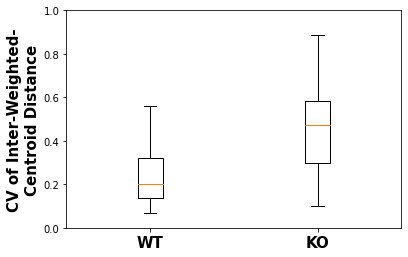

MannwhitneyuResult(statistic=396.0, pvalue=0.0009280627615406841)


In [8]:
plt.boxplot([cv_wt, cv_ko], )
plt.xticks([1, 2], ['WT', 'KO'], fontweight = 'bold', fontsize = 15)
plt.ylabel('CV of Inter-Weighted-\nCentroid Distance', fontweight = 'bold', fontsize = 15)
plt.ylim(0, 1)
plt.show()

print(stats.mannwhitneyu(cv_ko, cv_wt))

WT_Cell1_


/tmp/ipykernel_303218/877172390.py:29: UserWarning: No contour levels were found within the data range.
  plt.contour(BIN_Stack[I][T], levels = [False], colors = 'w', linestyles = '--')
/tmp/ipykernel_303218/877172390.py:62: UserWarning: No contour levels were found within the data range.
  plt.contour(BIN_Stack[I][T], levels = [False], colors = 'k', linestyles = '--')


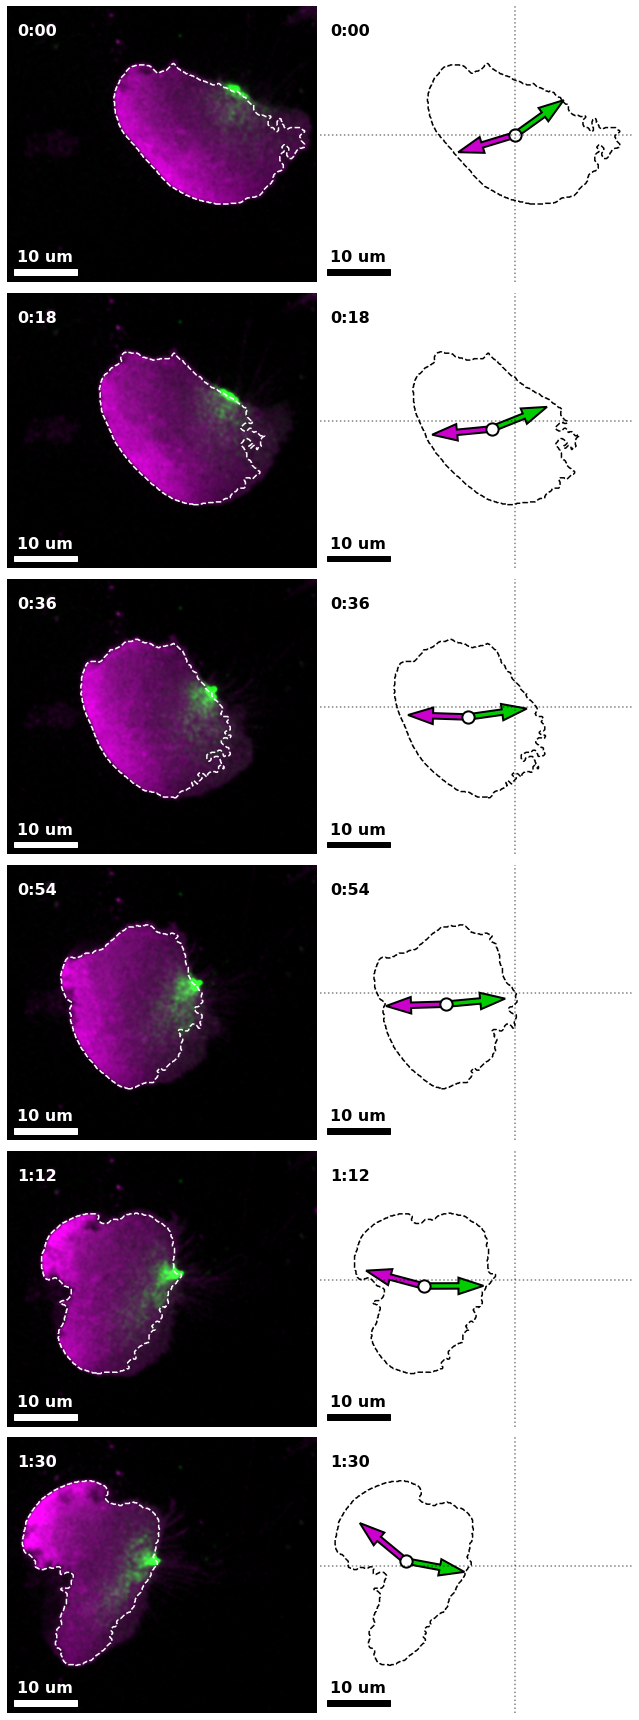

In [9]:
'''
Display some stills from one control cell
'''

I = 43 # id of a favorite control cell

microns_per_pixel = 0.11

r = normalize_image(PBD_Stack[I])
g = normalize_image(RBD_Stack[I])
b = normalize_image(PBD_Stack[I])
Z = np.zeros_like(r)
t, h, w = r.shape

print(kept_prefixes[I])

plt.figure(figsize = (9,24), facecolor = 'w')

count = 1
for T in range(0, 32, 6):
    ax1 = plt.subplot(6, 2, count)
    count += 1
    
    plt.imshow(np.dstack([r[T], g[T], b[T]]), origin = 'upper')
    Rect = mp.Rectangle((10, 10), 10/microns_per_pixel, 8, color = 'white')
    ax1.text(10 + 5/microns_per_pixel, 25, '10 um', va = 'bottom', ha = 'center', fontweight = 'bold', color = 'w', size = 16)
    ax1.add_patch(Rect)
    plt.axis('off')
    plt.axis([0, w, 0, h])
    
    plt.contour(BIN_Stack[I][T], levels = [False], colors = 'w', linestyles = '--')

    yc, xc = center_of_mass(BIN_Stack[I][T])
    yp, xp = center_of_mass(PBD_Stack[I][T], labels = BIN_Stack[I][T].astype(int), index = 1)
    yr, xr = center_of_mass(RBD_Stack[I][T], labels = BIN_Stack[I][T].astype(int), index = 1) 
    
    theta_r = np.arctan2((yr - yc), xr - xc)
    theta_p = np.arctan2((yp - yc), xp - xc)
    
    M = 50
    #ax1.arrow(xc, yc, M * np.cos(theta_p), M * np.sin(theta_p), width = 8, ec = 'k', linewidth = 2, facecolor = [0.8, 0, 0.8])
    #ax1.arrow(xc, yc, M * np.cos(theta_r), M * np.sin(theta_r), width = 8, ec = 'k', linewidth = 2, facecolor = [0, 0.8, 0])
    #plt.scatter(xc, yc, ec = 'k', facecolor = 'w', s = 100, linewidth = 2)
    
    
    ax1.text(15, h - 25, str(T*3//60).zfill(1) + ':' + str(T*3%60).zfill(2), va = 'top', ha = 'left', fontweight = 'bold', color = 'w', size = 16)
    
    plt.axis([0, w, 0, h])
    plt.axis('off')
    
    
    
    
    ax1 = plt.subplot(6, 2, count)
    count += 1
    
    #plt.imshow(np.dstack([r[T], g[T], b[T]]), origin = 'upper')
    Rect = mp.Rectangle((10, 10), 10/microns_per_pixel, 8, color = 'black')
    ax1.text(10 + 5/microns_per_pixel, 25, '10 um', va = 'bottom', ha = 'center', fontweight = 'bold', color = 'black', size = 16)
    ax1.add_patch(Rect)
    plt.axis('off')
    plt.axis([0, w, 0, h])
    
    plt.contour(BIN_Stack[I][T], levels = [False], colors = 'k', linestyles = '--')

    yc, xc = center_of_mass(BIN_Stack[I][T])
    yp, xp = center_of_mass(PBD_Stack[I][T], labels = BIN_Stack[I][T].astype(int), index = 1)
    yr, xr = center_of_mass(RBD_Stack[I][T], labels = BIN_Stack[I][T].astype(int), index = 1) 
    
    theta_r = np.arctan2((yr - yc), xr - xc)
    theta_p = np.arctan2((yp - yc), xp - xc)
    
    M = 50
    ax1.arrow(xc, yc, M * np.cos(theta_p), M * np.sin(theta_p), width = 8, ec = 'k', linewidth = 2, facecolor = [0.8, 0, 0.8])
    ax1.arrow(xc, yc, M * np.cos(theta_r), M * np.sin(theta_r), width = 8, ec = 'k', linewidth = 2, facecolor = [0, 0.8, 0])
    plt.scatter(xc, yc, ec = 'k', facecolor = 'w', s = 150, linewidth = 2)
    
    
    ax1.text(15, h - 25, str(T*3//60).zfill(1) + ':' + str(T*3%60).zfill(2), va = 'top', ha = 'left', fontweight = 'bold', color = 'k', size = 16)
    
    H, V = center_of_mass(BIN_Stack[I][0])
    plt.axvline(V, ls = ':', color = 'k', alpha = 0.5)
    plt.axhline(H, ls = ':', color = 'k', alpha = 0.5)
    
    plt.axis([0, w, 0, h])
    plt.xticks([])
    plt.yticks([])
    
    
    
plt.tight_layout()
plt.show()


RictorKO_Cell1_


/tmp/ipykernel_303218/2507537984.py:31: UserWarning: No contour levels were found within the data range.
  plt.contour(np.fliplr(BIN_Stack[I][T].T), levels = [False], colors = 'w', linestyles = '--')
/tmp/ipykernel_303218/2507537984.py:59: UserWarning: No contour levels were found within the data range.
  plt.contour(np.fliplr(BIN_Stack[I][T].T), levels = [False], colors = 'k', linestyles = '--')


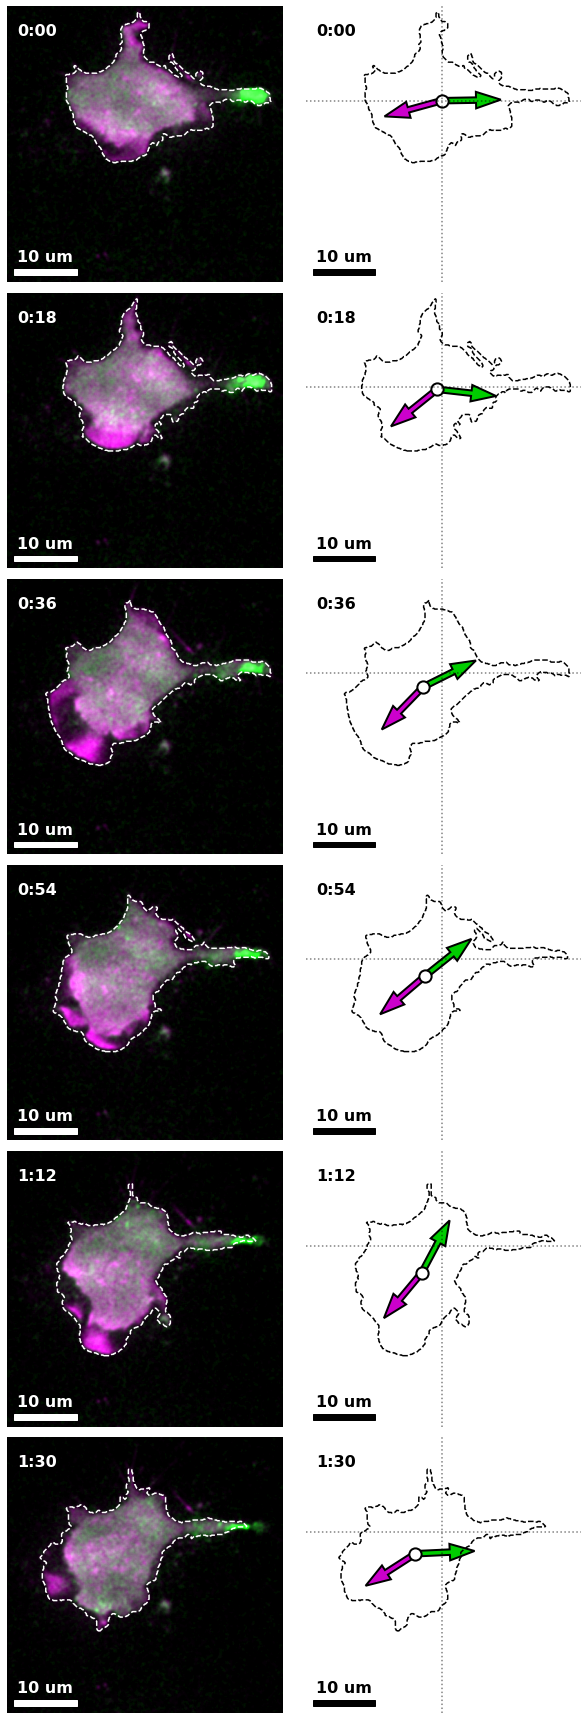

In [13]:
'''
Display some stills from one knockout cell, note that it is rotated/flipped to try to approximate the orientation
of the control cell above
'''

I = 27 # id for a favorite knockout cell

microns_per_pixel = 0.11

r = normalize_image(PBD_Stack[I])
g = normalize_image(RBD_Stack[I])
b = normalize_image(PBD_Stack[I])
Z = np.zeros_like(r)
t, h, w = r.shape

print(kept_prefixes[I])

plt.figure(figsize = (9,24), facecolor = 'w')

count = 1
for T in range(0, 32, 6):
    ax1 = plt.subplot(6, 2, count)
    count += 1
    
    plt.imshow(np.dstack([np.fliplr(r[T].T), np.fliplr(g[T].T), np.fliplr(b[T].T)]), origin = 'upper')
    Rect = mp.Rectangle((10, 10), 10/microns_per_pixel, 8, color = 'white')
    ax1.text(10 + 5/microns_per_pixel, 25, '10 um', va = 'bottom', ha = 'center', fontweight = 'bold', color = 'w', size = 16)
    ax1.add_patch(Rect)
    plt.axis('off')
    plt.axis([0, w, 0, h])
    
    plt.contour(np.fliplr(BIN_Stack[I][T].T), levels = [False], colors = 'w', linestyles = '--')

    yc, xc = center_of_mass(np.fliplr(BIN_Stack[I][T].T))
    yp, xp = center_of_mass(np.fliplr(PBD_Stack[I][T].T), labels = BIN_Stack[I][T].astype(int).T, index = 1)
    yr, xr = center_of_mass(np.fliplr(RBD_Stack[I][T].T), labels = BIN_Stack[I][T].astype(int).T, index = 1) 
    
    theta_r = np.arctan2((yr - yc), xr - xc)
    theta_p = np.arctan2((yp - yc), xp - xc)
    
    M = 50
    ax1.text(15, h - 25, str(T*3//60).zfill(1) + ':' + str(T*3%60).zfill(2), va = 'top', ha = 'left', fontweight = 'bold', color = 'w', size = 16)
    
    plt.axis([0, w, 0, h])
    plt.axis('off')
    
    
    
    
    ax1 = plt.subplot(6, 2, count, aspect = 'equal')
    count += 1
    
    #plt.imshow(np.dstack([r[T], g[T], b[T]]), origin = 'upper')
    Rect = mp.Rectangle((10, 10), 10/microns_per_pixel, 8, color = 'black')
    ax1.text(10 + 5/microns_per_pixel, 25, '10 um', va = 'bottom', ha = 'center', fontweight = 'bold', color = 'black', size = 16)
    ax1.add_patch(Rect)
    plt.axis('off')
    plt.axis([0, w, 0, h])
    
    plt.contour(np.fliplr(BIN_Stack[I][T].T), levels = [False], colors = 'k', linestyles = '--')

    yc, xc = center_of_mass(np.fliplr(BIN_Stack[I][T].T))
    yp, xp = center_of_mass(np.fliplr(PBD_Stack[I][T].T), labels = np.fliplr(BIN_Stack[I][T].T).astype(int), index = 1)
    yr, xr = center_of_mass(np.fliplr(RBD_Stack[I][T].T), labels = np.fliplr(BIN_Stack[I][T].T).astype(int), index = 1) 
    
    theta_r = np.arctan2((yr - yc), xr - xc)
    theta_p = np.arctan2((yp - yc), xp - xc)
    
    M = 50 # this factor just scales the arrows for visualization
    ax1.arrow(xc, yc, M * np.cos(theta_p), M * np.sin(theta_p), width = 8, ec = 'k', linewidth = 2, facecolor = [0.8, 0, 0.8])
    ax1.arrow(xc, yc, M * np.cos(theta_r), M * np.sin(theta_r), width = 8, ec = 'k', linewidth = 2, facecolor = [0, 0.8, 0])
    plt.scatter(xc, yc, ec = 'k', facecolor = 'w', s = 150, linewidth = 2)
    
    
    ax1.text(15, h - 25, str(T*3//60).zfill(1) + ':' + str(T*3%60).zfill(2), va = 'top', ha = 'left', fontweight = 'bold', color = 'k', size = 16)
    
    H, V = center_of_mass(np.fliplr(BIN_Stack[I][0].T))
    plt.axvline(V, ls = ':', color = 'k', alpha = 0.5)
    plt.axhline(H, ls = ':', color = 'k', alpha = 0.5)
    
    plt.axis([0, w, 0, h])
    plt.xticks([])
    plt.yticks([])
    
    
    
plt.tight_layout()
plt.show()


In [ ]:
'''
using the display format from above, create stills for a movie of a wildtype cell
'''

I = 43

microns_per_pixel = 0.11

r = normalize_image(PBD_Stack[I])
g = normalize_image(RBD_Stack[I])
b = normalize_image(PBD_Stack[I])
Z = np.zeros_like(r)
t, h, w = r.shape

print(kept_prefixes[I])


for T in range(0, 32):
    
    plt.figure(figsize = (9, 4), facecolor = 'w')
    
    count = 1
    
    ax1 = plt.subplot(1, 2, count)
    count += 1
    
    plt.imshow(np.dstack([r[T], g[T], b[T]]), origin = 'upper')
    Rect = mp.Rectangle((10, 10), 10/microns_per_pixel, 8, color = 'white')
    ax1.text(10 + 5/microns_per_pixel, 25, '10 um', va = 'bottom', ha = 'center', fontweight = 'bold', color = 'w', size = 16)
    ax1.add_patch(Rect)
    plt.axis('off')
    plt.axis([0, w, 0, h])
    
    plt.contour(BIN_Stack[I][T], levels = [False], colors = 'w', linestyles = '--')

    yc, xc = center_of_mass(BIN_Stack[I][T])
    yp, xp = center_of_mass(PBD_Stack[I][T], labels = BIN_Stack[I][T].astype(int), index = 1)
    yr, xr = center_of_mass(RBD_Stack[I][T], labels = BIN_Stack[I][T].astype(int), index = 1) 
    
    theta_r = np.arctan2((yr - yc), xr - xc)
    theta_p = np.arctan2((yp - yc), xp - xc)
    
    M = 50 # this factor just scales the arrows for visualization
    ax1.text(15, h - 25, str(T*3//60).zfill(1) + ':' + str(T*3%60).zfill(2), va = 'top', ha = 'left', fontweight = 'bold', color = 'w', size = 16)
    
    plt.axis([0, w, 0, h])
    plt.axis('off')
    
    
    
    
    ax1 = plt.subplot(1, 2, count, aspect = 'equal')
    count += 1
    
    #plt.imshow(np.dstack([r[T], g[T], b[T]]), origin = 'upper')
    Rect = mp.Rectangle((10, 10), 10/microns_per_pixel, 8, color = 'black')
    ax1.text(10 + 5/microns_per_pixel, 25, '10 um', va = 'bottom', ha = 'center', fontweight = 'bold', color = 'black', size = 16)
    ax1.add_patch(Rect)
    plt.axis('off')
    plt.axis([0, w, 0, h])
    
    plt.contour(BIN_Stack[I][T], levels = [False], colors = 'k', linestyles = '--')

    yc, xc = center_of_mass(BIN_Stack[I][T])
    yp, xp = center_of_mass(PBD_Stack[I][T], labels = BIN_Stack[I][T].astype(int), index = 1)
    yr, xr = center_of_mass(RBD_Stack[I][T], labels = BIN_Stack[I][T].astype(int), index = 1) 
    
    theta_r = np.arctan2((yr - yc), xr - xc)
    theta_p = np.arctan2((yp - yc), xp - xc)
    
    M = 50
    ax1.arrow(xc, yc, M * np.cos(theta_p), M * np.sin(theta_p), width = 8, ec = 'k', linewidth = 2, facecolor = [0.8, 0, 0.8])
    ax1.arrow(xc, yc, M * np.cos(theta_r), M * np.sin(theta_r), width = 8, ec = 'k', linewidth = 2, facecolor = [0, 0.8, 0])
    plt.scatter(xc, yc, ec = 'k', facecolor = 'w', s = 150, linewidth = 2)
    
    
    ax1.text(15, h - 25, str(T*3//60).zfill(1) + ':' + str(T*3%60).zfill(2), va = 'top', ha = 'left', fontweight = 'bold', color = 'k', size = 16)
    
    H, V = center_of_mass(BIN_Stack[I][0])
    plt.axvline(V, ls = ':', color = 'k', alpha = 0.5)
    plt.axhline(H, ls = ':', color = 'k', alpha = 0.5)
    
    plt.axis([0, w, 0, h])
    plt.xticks([])
    plt.yticks([])
    
    plt.tight_layout()
    plt.savefig('/home/jason/Data/forSS_controlMovie/' + str(T).zfill(3) + '.png')
    plt.close()
    

In [ ]:
'''
using the display format from above, create stills for a movie of a knockout cell
note that it is rotated and flipped to approximate the orientation of the cell above
'''

I = 27


microns_per_pixel = 0.11

r = normalize_image(PBD_Stack[I])
g = normalize_image(RBD_Stack[I])
b = normalize_image(PBD_Stack[I])
Z = np.zeros_like(r)
t, h, w = r.shape

print(kept_prefixes[I])


for T in range(0, 32):
    
    plt.figure(figsize = (9, 4), facecolor = 'w')
    
    count = 1
    
    ax1 = plt.subplot(1, 2, count)
    count += 1
    
    plt.imshow(np.dstack([np.fliplr(r[T].T), np.fliplr(g[T].T), np.fliplr(b[T].T)]), origin = 'upper')
    Rect = mp.Rectangle((10, 10), 10/microns_per_pixel, 8, color = 'white')
    ax1.text(10 + 5/microns_per_pixel, 25, '10 um', va = 'bottom', ha = 'center', fontweight = 'bold', color = 'w', size = 16)
    ax1.add_patch(Rect)
    plt.axis('off')
    plt.axis([0, w, 0, h])
    
    plt.contour(np.fliplr(BIN_Stack[I][T].T), levels = [False], colors = 'w', linestyles = '--')

    yc, xc = center_of_mass(np.fliplr(BIN_Stack[I][T].T))
    yp, xp = center_of_mass(np.fliplr(PBD_Stack[I][T].T), labels = BIN_Stack[I][T].astype(int).T, index = 1)
    yr, xr = center_of_mass(np.fliplr(RBD_Stack[I][T].T), labels = BIN_Stack[I][T].astype(int).T, index = 1) 
    
    theta_r = np.arctan2((yr - yc), xr - xc)
    theta_p = np.arctan2((yp - yc), xp - xc)
    
    M = 50
    ax1.text(15, h - 25, str(T*3//60).zfill(1) + ':' + str(T*3%60).zfill(2), va = 'top', ha = 'left', fontweight = 'bold', color = 'w', size = 16)
    
    plt.axis([0, w, 0, h])
    plt.axis('off')
    
    
    
    
    ax1 = plt.subplot(1, 2, count, aspect = 'equal')
    count += 1
    
    #plt.imshow(np.dstack([r[T], g[T], b[T]]), origin = 'upper')
    Rect = mp.Rectangle((10, 10), 10/microns_per_pixel, 8, color = 'black')
    ax1.text(10 + 5/microns_per_pixel, 25, '10 um', va = 'bottom', ha = 'center', fontweight = 'bold', color = 'black', size = 16)
    ax1.add_patch(Rect)
    plt.axis('off')
    plt.axis([0, w, 0, h])
    
    plt.contour(np.fliplr(BIN_Stack[I][T].T), levels = [False], colors = 'k', linestyles = '--')

    yc, xc = center_of_mass(np.fliplr(BIN_Stack[I][T].T))
    yp, xp = center_of_mass(np.fliplr(PBD_Stack[I][T].T), labels = np.fliplr(BIN_Stack[I][T].T).astype(int), index = 1)
    yr, xr = center_of_mass(np.fliplr(RBD_Stack[I][T].T), labels = np.fliplr(BIN_Stack[I][T].T).astype(int), index = 1) 
    
    theta_r = np.arctan2((yr - yc), xr - xc)
    theta_p = np.arctan2((yp - yc), xp - xc)
    
    M = 50 # this factor just scales the arrows for visualization
    ax1.arrow(xc, yc, M * np.cos(theta_p), M * np.sin(theta_p), width = 8, ec = 'k', linewidth = 2, facecolor = [0.8, 0, 0.8])
    ax1.arrow(xc, yc, M * np.cos(theta_r), M * np.sin(theta_r), width = 8, ec = 'k', linewidth = 2, facecolor = [0, 0.8, 0])
    plt.scatter(xc, yc, ec = 'k', facecolor = 'w', s = 150, linewidth = 2)
    
    
    ax1.text(15, h - 25, str(T*3//60).zfill(1) + ':' + str(T*3%60).zfill(2), va = 'top', ha = 'left', fontweight = 'bold', color = 'k', size = 16)
    
    H, V = center_of_mass(np.fliplr(BIN_Stack[I][0].T))
    plt.axvline(V, ls = ':', color = 'k', alpha = 0.5)
    plt.axhline(H, ls = ':', color = 'k', alpha = 0.5)
    
    plt.axis([0, w, 0, h])
    plt.xticks([])
    plt.yticks([])
    
    plt.tight_layout()
    plt.savefig('/home/jason/Data/forSS_knockoutMovie/' + str(T).zfill(3) + '.png')
    plt.close()

In [ ]:
'''
print out data from calculations of inter-centroid distances
'''

for i in range(len(cv_wt)):
    print([kept_prefixes[j][:-1] for j in wt_data][i] + '\t' +  str(cv_wt[i]))

print()

for i in range(len(cv_ko)):
    print([kept_prefixes[j][:-1] for j in ko_data][i] + '\t' +  str(cv_ko[i]))


In [ ]:
'''
print out data from calculations of inter-centroid distances
'''

for i in range(len(kept_prefixes)):
    print(kept_prefixes[i])
    print(ALL_ID[i])
    print()